# Import Libraries & Load Dataset

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("insurance.csv")

df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Dataset Overview 

In [8]:
df.shape

(1338, 7)

In [9]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   str    
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   str    
 5   region    1338 non-null   str    
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), str(3)
memory usage: 94.5 KB


In [13]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Data Cleaning

In [14]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [15]:
df.duplicated().sum()

1

### Remove duplicates

# Exploratory Data Analysis (EDA)

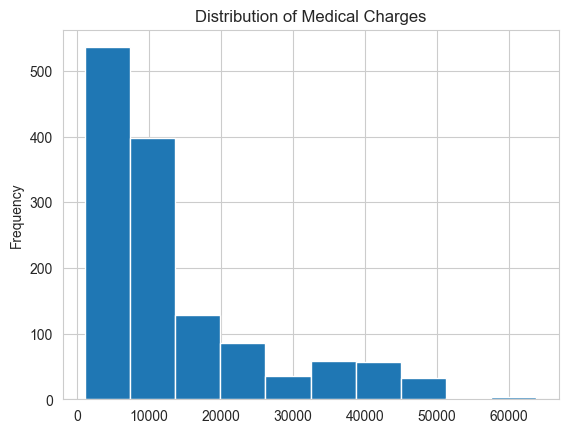

In [16]:
df['charges'].plot(kind='hist')
plt.title("Distribution of Medical Charges")
plt.show()

# Average Charges by Smoker

In [17]:
df.groupby('smoker')['charges'].mean()

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

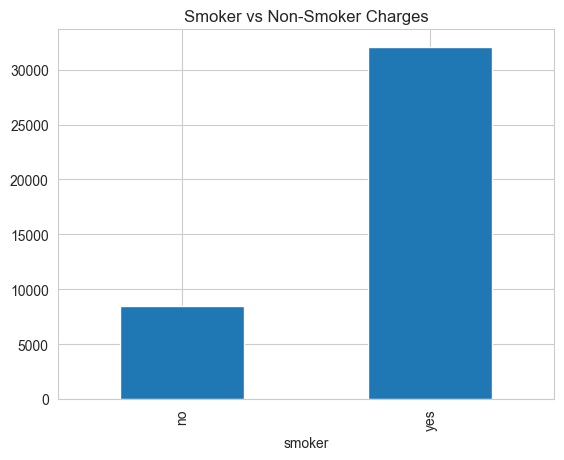

In [18]:
df.groupby('smoker')['charges'].mean().plot(kind='bar')
plt.title("Smoker vs Non-Smoker Charges")
plt.show()

# Charges vs Age

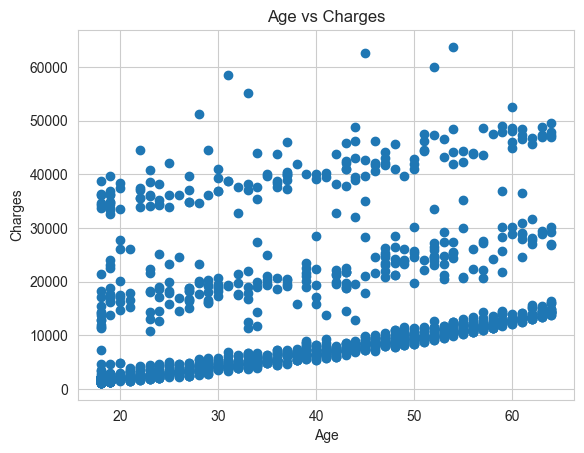

In [19]:
plt.scatter(df['age'], df['charges'])
plt.title("Age vs Charges")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

# Charges vs BMI

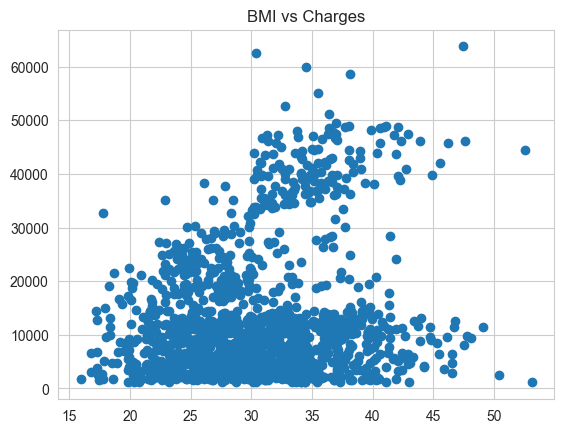

In [20]:
plt.scatter(df['bmi'], df['charges'])
plt.title("BMI vs Charges")
plt.show()

# Regional Analysis

In [21]:
df.groupby('region')['charges'].mean()

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

# Feature Engineering

### Create BMI Category

In [24]:
df['bmi_category'] = pd.cut(
    df['bmi'],
    bins=[0,18.5,25,30,100],
    labels=['Underweight','Normal','Overweight','Obese']
)

### Age Group

In [25]:
df['age_group'] = pd.cut(
    df['age'],
    bins=[0,30,45,60,100],
    labels=['Young','Middle','Senior','Elder']
)

# Correlation Analysis

In [26]:
df[['age','bmi','children','charges']].corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


# Outlier Detection (Medical Charges)

In [27]:
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)
iqr = q3 - q1

upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

outliers = df[(df['charges'] > upper) | (df['charges'] < lower)]
len(outliers)


139

# Smoker Cost Impact (Very Important KPI)

In [28]:
smoker_cost = df.groupby('smoker')['charges'].mean()
smoker_cost

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

# Age × Smoker Risk Matrix

In [29]:
pivot_age_smoker = df.pivot_table(
    values='charges',
    index='age_group',
    columns='smoker',
    aggfunc='mean'
)

pivot_age_smoker


smoker,no,yes
age_group,,
Young,4462.308505,27528.078343
Middle,7246.170138,31707.164316
Senior,12188.334036,36451.732069
Elder,15366.613482,38929.615407


# BMI Category vs Charges

In [30]:
df.groupby('bmi_category')['charges'].mean()

bmi_category
Underweight     8657.620652
Normal         10435.440719
Overweight     10997.803881
Obese          15560.926321
Name: charges, dtype: float64

# Region + Smoker Combined Analysis

In [31]:
df.pivot_table(values='charges', index='region', columns='smoker', aggfunc='mean')

smoker,no,yes
region,,
northeast,9165.531672,29673.536473
northwest,8556.463715,30192.003182
southeast,8032.216309,34844.996824
southwest,8019.284513,32269.063494


# Revenue Concentration (Pareto Rule)

In [32]:
df_sorted = df.sort_values('charges', ascending=False)

top20 = df_sorted.head(int(len(df)*0.2))

top20['charges'].sum() / df['charges'].sum() * 100


51.57134811367937

# Custom Risk Score

In [33]:
df['risk_score'] = (
    df['age']/df['age'].max()*0.3 +
    df['bmi']/df['bmi'].max()*0.3 +
    (df['smoker']=='yes').astype(int)*0.4
)

df[['age','bmi','smoker','risk_score']].head()


,age,bmi,smoker,risk_score
0,19,27.900,yes,0.646601
1,18,33.770,no,0.275058
2,28,33.000,no,0.317585
3,33,22.705,no,0.282892
4,32,28.880,no,0.313072


# Cost Segmentation

In [34]:
df['cost_segment'] = pd.qcut(df['charges'],3,labels=['Low','Medium','High'])
df['cost_segment'].value_counts()


cost_segment
Low       446
Medium    446
High      446
Name: count, dtype: int64

# Final Conclusion

### Medical insurance costs are primarily driven by smoking habits, age, and BMI. Implementing risk-based pricing and preventive healthcare strategies can significantly reduce claim expenses and improve business sustainability.